<a href="https://colab.research.google.com/github/eunrod16/MachineDeepLearning/blob/master/ProyectoML2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Sentiment Analysis Financial Tweets
El problema es realizar un análisis de sentimiento con tweets financieros, se limito a 0 y 1 (positivos y negativos)

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("/content/drive/My Drive/tweet_sentiment.csv", encoding='latin-1') 
data.head()
data = data.fillna('')
data = data[data.sentiment != 0]
data.sentiment[data.sentiment == -1] = 0
data.describe()

,sentiment
count,11110.000000
mean,0.766157
std,0.423293
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


## Tokenizer y Pad Sequences

In [3]:

X, y = (data['cleaned_tweets'].values, data['sentiment'].values)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tk = Tokenizer()
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.25, random_state = 1)
vocab_size = len(tk.word_counts.keys())+1
np.array(X_train)

Using TensorFlow backend.


array([[   1, 1151,   38, ...,    0,    0,    0],
       [ 653,  305,  135, ...,    0,    0,    0],
       [1756,    6,  112, ...,    0,    0,    0],
       ...,
       [   1, 2060,  753, ...,    0,    0,    0],
       [1440,   39, 1441, ...,    0,    0,    0],
       [1328, 1945, 3433, ...,    0,    0,    0]], dtype=int32)

## RNN con LSTM

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torch import nn
train_data = TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).long())
test_data = TensorDataset(torch.from_numpy(X_test).long(), torch.from_numpy(y_test).long())

batchSize = 500
train_loader = DataLoader(train_data, batch_size = batchSize, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batchSize, shuffle = True)

In [0]:
def checkpointModel():
    torch.save(model.state_dict(), "bestModel.model")
    print("Checkpoint saved")

In [0]:
def accuracy(y_hat, y):
    y_hat = torch.round(torch.sigmoid(y_hat))
    correct = (y_hat == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [0]:


class LSTM(nn.Module):
    
    def __init__(self, inputs, embedings, hiddens, outputs, layers, drop_p = 0.5):
        super().__init__()
        self.inputs = inputs   
        self.layers = layers  
        self.hiddens = hiddens      
        self.embedding = nn.Embedding(inputs, embedings)
        self.lstm = nn.LSTM(embedings, hiddens, layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.H = nn.Linear(hiddens, outputs)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward (self, wordsInput):
                          
        embeds = self.embedding(wordsInput)   
        out, h = self.lstm(embeds)       
        out = self.dropout(out)
        size = out.shape[0]
        out = self.H(out.contiguous().view(-1, self.hiddens) )                    
        out = self.sigmoid(out) 
        out = out.view(size, -1)       
        out = out[:, -1]                 
        return out, h
    
    
    def init_hidden (self, batchSize): 
        w = next(self.parameters()).data
        h = (w.new(self.layers, batchSize, self.hiddens).zero_().to("cpu"),  #fill weights with zeros
             w.new(self.layers, batchSize, self.hiddens).zero_().to("cpu"))
        
        return h

In [0]:
def initModel():
  inputs = vocab_size
  embeds = 400
  hiddens = 512
  outputs = 1  
  layers = 2

  model = LSTM(inputs, embeds, hiddens, outputs, layers)
  return model

## Entrenamiento

In [9]:
model = initModel()
model.train()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
epochs = 2
clip = 5
errores = []
for epoch in range(epochs):
    h = model.init_hidden(batchSize)
    batch = 0
    for inputs, labels in train_loader:
        batch += 1
        inputs, labels = inputs.to('cpu'), labels.to('cpu')
        h = tuple([each.data for each in h])   
        
        model.zero_grad()
        y_hat, h = model(inputs)

        if(y_hat.shape==labels.shape):
          loss = criterion(y_hat.squeeze(), labels.float())
          acc = accuracy(y_hat.squeeze(), labels.float())
          loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        errores.append(loss.item())
        print("Epoch: {}".format((epoch+1)),
                  "Batch: {}".format(batch),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Accuracy: {:.4f}".format(acc))
checkpointModel()    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 1 Batch: 1 Training Loss: 0.6746 Accuracy: 0.7880
Epoch: 1 Batch: 2 Training Loss: 2.0529 Accuracy: 0.7400
Epoch: 1 Batch: 3 Training Loss: 1.0087 Accuracy: 0.7740
Epoch: 1 Batch: 4 Training Loss: 0.6111 Accuracy: 0.7240
Epoch: 1 Batch: 5 Training Loss: 0.6633 Accuracy: 0.7720
Epoch: 1 Batch: 6 Training Loss: 0.6352 Accuracy: 0.7480
Epoch: 1 Batch: 7 Training Loss: 0.5749 Accuracy: 0.7980
Epoch: 1 Batch: 8 Training Loss: 0.5470 Accuracy: 0.7820
Epoch: 1 Batch: 9 Training Loss: 0.5330 Accuracy: 0.7800
Epoch: 1 Batch: 10 Training Loss: 0.5108 Accuracy: 0.7920
Epoch: 1 Batch: 11 Training Loss: 0.5387 Accuracy: 0.7800
Epoch: 1 Batch: 12 Training Loss: 0.5752 Accuracy: 0.7600
Epoch: 1 Batch: 13 Training Loss: 0.5730 Accuracy: 0.7640
Epoch: 1 Batch: 14 Training Loss: 0.5757 Accuracy: 0.7600
Epoch: 1 Batch: 15 Training Loss: 0.5630 Accuracy: 0.7620
Epoch: 1 Batch: 16 Training Loss: 0.5473 Accuracy: 0.7720
Epoch: 1 Batch: 17 Training Loss: 0.5511 Accuracy: 0.7681
Epoch: 2 Batch: 1 Train

In [10]:
checkpoint = torch.load("bestModel.model")
model = initModel()
model.load_state_dict(checkpoint)
model.eval()

LSTM(
  (embedding): Embedding(9497, 400)
  (lstm): LSTM(400, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (H): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Evaluación

In [0]:
from sklearn.metrics import f1_score

In [12]:

lossesMean = []
h = model.init_hidden(batchSize)

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    y_hat, h = model(inputs)
    if(y_hat.shape==labels.shape): 
      loss = criterion(y_hat, labels.float())
      lossesMean.append(loss.item())
      acc = accuracy(y_hat.squeeze(), labels.float())
    
print("Loss: {:.4f}".format(np.mean(lossesMean)),
      "Accuracy: {:.2f}".format(acc),
     ' F1 Score: {}'.format(f1_score(y_hat.squeeze().detach().numpy()> 0.5, labels.detach().numpy(), average='macro')  ))



Loss: 0.5568 Accuracy: 0.75  F1 Score: 0.4279835390946502


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


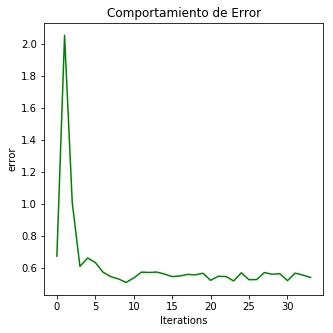

In [13]:
fig,ax = plt.subplots(figsize=(5,5))
ax.set_ylabel('error')
ax.set_xlabel('Iterations')
ax.set_title('Comportamiento de Error')
_=ax.plot(range(len(errores)),errores,'g')

## Conclusiones


*   Se necesitan una buena cantidad de data para que el algoritmo pueda aprender.
*   LSTM es utilizado para la resolución de esyte problema por su propiedad de trabajar con memoria.
*   Se realiza tokenizer y pad sequences para obtener un vector de las palabras y así con ello poder trabajar.
*   De igual manera se realiza word embeding que es un tipo vector diccionario como capa del modelo.
*   Es nececario regulalizarlo con dropout para mejores resultados.
*   Sigmoid es excelente como función de activación en capa final.

